# 0.Import Libraries

In [2]:
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn as nn
from torch import optim as optim
from torchmetrics import Precision, Recall

import ClassNet

ModuleNotFoundError: No module named 'torchvision'

# 1.Loading Image Files
## 1.1 Define the transformers

In [161]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

## 1.2 Define the ImageFolders

In [162]:
dataset_train = ImageFolder("clouds_train/",transform=train_transforms)
dataset_test = ImageFolder("clouds_test/", transform=test_transforms)

## 1.3 Creating DataLoader

In [163]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle = True,
    batch_size=1
)

dataloader_test = DataLoader(
    dataset_test,
    shuffle = True,
    batch_size=1
)

image, label = next(iter(dataloader_train))
print(image.shape) # 1 represent batch size, 3 represent 3 color

torch.Size([1, 3, 64, 64])


## 1.4 Squeeze Batch Dimension and Display the Image using imshow

In [164]:
image = image.squeeze().permute(1,2,0)
print(image.shape)

torch.Size([64, 64, 3])


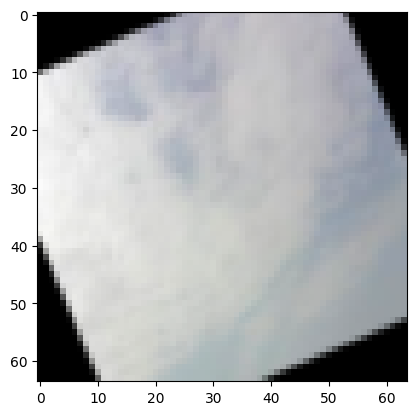

In [165]:
plt.imshow(image)
plt.show()

# 2.Convolutional Neural Networks
## 2.1 Create instance for model

In [166]:
num_classes = 7
convo_model = ClassNet.ConvoNet(num_classes=num_classes)

## 2.2 Defining Loss Function and Optimizers

In [167]:
torch.cuda.is_available()

False

In [168]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [169]:
get_default_device()

device(type='cpu')

In [170]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convo_model.parameters(), lr=0.001)

# 3.Training Loop

In [171]:
for epoch in range(50):    
    convo_model.train()
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = convo_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 1.9361
Epoch 2, Loss: 1.7165
Epoch 3, Loss: 1.6522
Epoch 4, Loss: 1.5915
Epoch 5, Loss: 1.5286
Epoch 6, Loss: 1.4922
Epoch 7, Loss: 1.5203
Epoch 8, Loss: 1.3526
Epoch 9, Loss: 1.4029
Epoch 10, Loss: 1.2538
Epoch 11, Loss: 1.2338
Epoch 12, Loss: 1.4203
Epoch 13, Loss: 1.3124
Epoch 14, Loss: 1.1393
Epoch 15, Loss: 1.3039
Epoch 16, Loss: 1.1452
Epoch 17, Loss: 1.3247
Epoch 18, Loss: 1.1239
Epoch 19, Loss: 1.0686
Epoch 20, Loss: 1.0179
Epoch 21, Loss: 1.2535
Epoch 22, Loss: 1.2313
Epoch 23, Loss: 1.0845
Epoch 24, Loss: 1.1710
Epoch 25, Loss: 1.0322
Epoch 26, Loss: 1.0540
Epoch 27, Loss: 1.2721
Epoch 28, Loss: 0.9392
Epoch 29, Loss: 1.3781
Epoch 30, Loss: 1.0687
Epoch 31, Loss: 0.9920
Epoch 32, Loss: 0.9269
Epoch 33, Loss: 0.9955
Epoch 34, Loss: 0.9688
Epoch 35, Loss: 1.0321
Epoch 36, Loss: 1.2067
Epoch 37, Loss: 0.8139
Epoch 38, Loss: 0.8826
Epoch 39, Loss: 0.9152
Epoch 40, Loss: 1.0114
Epoch 41, Loss: 1.0323
Epoch 42, Loss: 0.8093
Epoch 43, Loss: 1.2954
Epoch 44, Loss: 0.96

# 4.Evaluation Loop

In [172]:
metric_precision = Precision(
    task="multiclass",
    num_classes=7,
    average="macro"
)

metric_recall = Recall(
    task="multiclass",
    num_classes=7,
    average="macro"
)

In [173]:
convo_model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = convo_model(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()

In [174]:
print(f"Precision : {precision}")
print(f"Recall : {recall}")

Precision : 0.5909356474876404
Recall : 0.6444304585456848


In [175]:
metric_recall_per_class = Recall(
    task="multiclass",
    num_classes=7,
    average=None
)

convo_model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = convo_model(images)
        _, preds = torch.max(outputs, 1)
        metric_recall_per_class(preds, labels)

recall_per_class = metric_recall_per_class.compute()
print(recall_per_class)

tensor([0.8571, 0.8281, 0.9091, 0.4833, 0.4175, 0.8750, 0.1408])


In [176]:
dataset_test.class_to_idx

{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}

In [177]:
# Get precision per class
recall_per_class_dict = {
    k: recall_per_class[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}

In [178]:
recall_per_class_dict

{'cirriform clouds': 0.8571428656578064,
 'clear sky': 0.828125,
 'cumulonimbus clouds': 0.9090909361839294,
 'cumulus clouds': 0.4833333194255829,
 'high cumuliform clouds': 0.41747573018074036,
 'stratiform clouds': 0.875,
 'stratocumulus clouds': 0.14084507524967194}

## Results with epoch 20 

    {'cirriform clouds': 0.4285714328289032,
     'clear sky': 1.0,
     'cumulonimbus clouds': 0.9090909361839294,
     'cumulus clouds': 0.5583333373069763,
     'high cumuliform clouds': 0.48543688654899597,
     'stratiform clouds': 0.875,
     'stratocumulus clouds': 0.5070422291755676}
 
 
## Results with epoch 50

    {'cirriform clouds': 0.8571428656578064,
     'clear sky': 0.828125,
     'cumulonimbus clouds': 0.9090909361839294,
     'cumulus clouds': 0.4833333194255829,
     'high cumuliform clouds': 0.41747573018074036,
     'stratiform clouds': 0.875,
     'stratocumulus clouds': 0.14084507524967194}